Code Lab 1: Skin Cancer MNIST
=========================

## The Problem

From ISIC 2018: Skin Lesion Analysis Website [https://challenge2018.isic-archive.com]

> Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

## Imports
Using the `Snippets` Jupyter nbextension makes starting a notebook very easy.  A very common block of imports to use is given in the `Snippets > Matplotlib > Setup for notebook`

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import pandas as pd
from IPython.display import display, HTML

Let's import Tensorflow now.  It is helpful after importing Tensorflow to check the version of the library installed since the API's are changing so quickly.  Several machines are now starting to use Tensorflow 2.0rc which has a very different interface from v1.* as well.

In [3]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))

Tensorflow version:  1.13.1
Is GPU available: True


## Dataset

### About HAM10000

In this exercise will will be using  HAM10000 ("Human Against Machine with 10000 training images") dataset which is a collection of "dermatoscopic images from different populations, acquired and stored by different modalities."[Kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000) This dataset has ~10K dermatoscopic images that have been reformatted to be similar to the famous Handwritten Digit or MNIST dataset (28 x 28 images centered on the subject).  This allows us to focus on setting up our environment and making sure we can get a model working on a more interesting, healthcare-related problem.

### Load the dataset

We will load both the included meta file as well as the image data (provided conveniently as a CSV file with one row per image.

In [7]:
IS_ONEPANEL = False
NEED_DOWNLOAD = False
if IS_ONEPANEL:
    DATA_DIR='/onepanel/input'
else:
    import load_data
    DATA_DIR = '/storage/codelab1'
    if NEED_DOWNLOAD:
        os.mkdir(DATA_DIR)
        FILELIST = ['HAM10000_metadata.csv','hmnist_28_28_RGB.csv']
        load_data.download_files(FILELIST,DATA_DIR)

In [8]:
meta_df = pd.read_csv(os.path.join(DATA_DIR,'HAM10000_metadata.csv'))
img_df = pd.read_csv(os.path.join(DATA_DIR,'hmnist_28_28_RGB.csv'))

We will split the `img_df` or image dataframe into an image numpy array (img_array) as well as a `lbl_array`, which contains the target classes.

In [9]:
img_array = img_df.values[:,:-1].reshape(-1,28,28,3)
lbl_array = img_df.values[:,-1]

### Inspect the meta data

#### Lesions with multiple images

For each image we have a `lesion_id` as well as a an `image_id`.  We should note that there are in fact multiple images for the same lesion which we need to be mindful of as we construct our training and testing splits.

In [10]:
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Below, we count the occurrences of a lesion_id, accumulate the lesions ids with more than 1 image and then add a flag to our original meta_df to indicate whether the lesion has more than one image in the dataset.

In [11]:
def pretty_count_print(series):
    display(pd.DataFrame(series.value_counts()))

In [12]:
lesion_image_counts = pd.DataFrame( meta_df.groupby('lesion_id')['image_id'].count())
dupe_lesion_ids = list(lesion_image_counts[lesion_image_counts['image_id'] > 1].index.values)
meta_df['dupe'] = meta_df.apply(lambda row: row['lesion_id'] in dupe_lesion_ids, axis=1)
pretty_count_print(meta_df['dupe'])

,dupe
False,5514
True,4501


### Classes

The dataset contains 7 classes of lesions, a mixture of both benign and cancerous types.  The dataset is overweight to benign melanocytic nevi, a harmless mole.  However, there are over 2,000 examples of cancerous lesions to detect in this dataset.


| Id |Abbr | Name |
|---|---|---|
| 5 | nv | Melanocytic nevi |
| 4 | mel | Melanoma |
| 2 | bkl | Benign keratosis-like lesion |
| 1 | bcc | Basal cell carcinoma |
| 0 | akiec |  Actinic keratoses |
| 6 | vasc | Vascular lesions (angiomas, etc.) |
| 3 | df | Dermatofibroma |

In [13]:
class_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
pretty_count_print(meta_df['dx'])

,dx
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


Let's gather examples of each class to inspect visually.

In [14]:
example_list = {}
for cls in class_list:
    example_list[cls] = meta_df[meta_df['dx']==cls].index[0]
display(example_list)

{'akiec': 9687,
 'bcc': 2462,
 'bkl': 0,
 'df': 1095,
 'mel': 1211,
 'nv': 64,
 'vasc': 2320}

In [30]:
class_counts = np.array([327, 514, 1099,115,1113,6705,142],dtype=np.float32)
total_count = np.sum(class_counts)
weights = np.log(total_count * np.reciprocal(class_counts))
weights

array([3.421879 , 2.969616 , 2.2096834, 4.466907 , 2.1970248, 0.4012305,
       4.256012 ], dtype=float32)

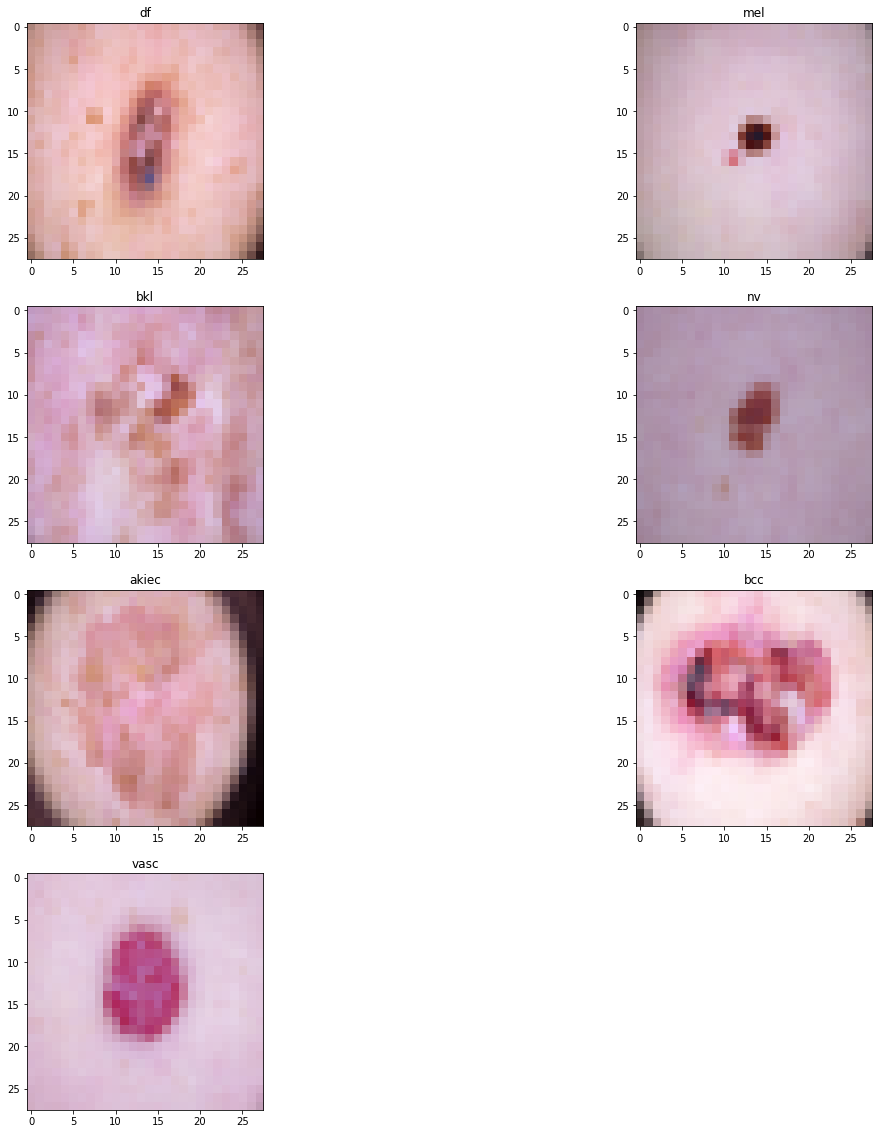

In [15]:
fig, ax = plt.subplots(4,2, figsize=(20,20))
fig.delaxes(ax[3,1]) # Delete the extra plot
for i, (key, value) in enumerate(example_list.items()):
    ax[i//2,i%2].title.set_text(key)
    ax[i//2,i%2].imshow(img_array[value])

### Prepare the data

For this step we will split the dataset into two parts: 1) a training set on which the parameters of the neural network model will be learning, 2) a held-out evaluation set that we will use to score the performance of our model.  Also we will preprocess our data and build functions for feeding our data to our model according to the Estimator API.

#### Train/Test Split

Let us hold out 20% of the data that we have as a test set.  Since there are multiple images of the same lesion in the dataset, we need to make sure that only lesions with one image are included in the test set.  Otherwise information will leak from the training set to the dataset and invalidate our assumption that the model has never seen any of the test set during training. 

In [16]:
test_frac = 0.2
test_idx = list(meta_df[meta_df['dupe'] != True]
                .sample(int(test_frac * len(meta_df)),random_state=42)
                .index.values)
test_mask = [ x in test_idx for x in range(len(meta_df))]
train_mask = [ not(x) for x in test_mask]

#### Preprocessing

Uniquely with toy datasets like this one, there is not much in the way of preprocessing to accomplish.  We will simply scale the 8-bit color values down to a range between \[0,1] to help keep the gradients from exploding during training.

In [65]:
train_x, train_y_idx = img_array[train_mask] / 255. , lbl_array[train_mask]
test_x, test_y_idx = img_array[test_mask] / 255. , lbl_array[test_mask]

In [66]:
train_weights = np.array([ weights[x] for x in train_y_idx ])
test_weights = np.array([ weights[x] for x in test_y_idx ])

In [67]:
# train_y = tf.keras.utils.to_categorical(train_y_idx)
# test_y = tf.keras.utils.to_categorical(test_y_idx)
train_y = train_y_idx
test_y = test_y_idx

In [68]:
print(train_x.shape, train_y.shape, train_weights.shape)
print(test_x.shape, test_y.shape, test_weights.shape)

(8012, 28, 28, 3) (8012,) (8012,)
(2003, 28, 28, 3) (2003,) (2003,)


#### Data Loading functions

These functions will load all of the data into the device memory in a format that the Estimator API expects for input (specifically as a dictionary of tensors).  The Estimator API has a convenience function that directly creates this loader from numpy arrays.  For larger datasets, we will need a different approach.

In [69]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_x, "weights": train_weights},
    y=train_y,
    batch_size=128,
    num_epochs=None,
    shuffle=True)

In [70]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_x, "weights": test_weights},
    y=test_y,
    batch_size=64,
    num_epochs=1,
    shuffle=False)

## Model

Now we will construct the model using the Tensorflow Estimator API.  The first step is to create a function that build a graph and returns an instance of `EstimatorSpec`.

In [72]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN.  Adapted from https://www.tensorflow.org/tutorials/estimators/cnn"""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 3])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=128,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
  # Convolutional Layer #3 and Pooling Layer #3
  conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=256,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[7, 7], strides=1)

  # Dense Layer
  pool3_flat = tf.reshape(pool3, [-1, 256])
#   dense = tf.layers.dense(inputs=pool3_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=pool3_flat, rate=0.35, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=7)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

  loss = cce(labels, logits, features['weights'])

  # loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.MomentumOptimizer(learning_rate=0.0005, momentum=0.9,use_nesterov=True)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

#   label_cat = tf.argmax(input=labels,axis=1)
  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [73]:
ham_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="output/model3")

## Train

TALK ABOUT TENSORBOARD AND ALL OF THE THINGS ESTIMATOR GIVES YOU FOR FREE

In [ ]:
ham_classifier.train(input_fn=train_input_fn, steps=3000)

## Evaluation

### Score the Model

In [ ]:
eval_results = ham_classifier.evaluate(input_fn=test_input_fn)
print(eval_results)

### Inspect Predictions

### Inspect feature vector

In [ ]:
'a'